In [23]:
import torch
from torchvision import datasets, transforms
from torchvision.io import decode_image
from torch.utils.data import DataLoader, Dataset

import numpy as np

import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path

import os
from tqdm import tqdm

from model import MLP
from data import GenerativeImageDataset

In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

In [ ]:
# extract zeros + Resize + Store
# mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Resize(14))

# save_dir = Path("./mnist_zeros")
# save_dir.mkdir(parents=True, exist_ok=True)

# count = 0
# for idx, (img, label) in enumerate(mnist):
#     if label == 0:
#         img.save(save_dir / f"zero_{count}.png")
#         count += 1



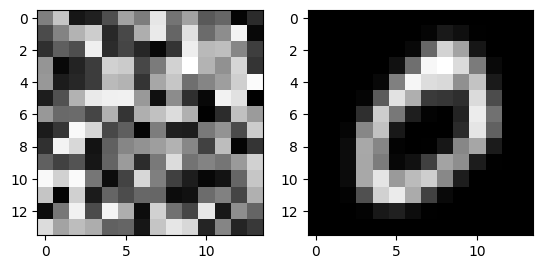

In [3]:
dataset = GenerativeImageDataset('mnist_zeros')
img = dataset[0][0]
noise = dataset[0][1]

noise_norm = (noise + torch.min(noise))/(torch.max(noise) - torch.min(noise))

fig, ax = plt.subplots(1,2)
ax[0].imshow(noise_norm[0], cmap='grey')
ax[1].imshow(img[0], cmap='grey')

In [4]:
dataloader = DataLoader(dataset, 1, drop_last=True)

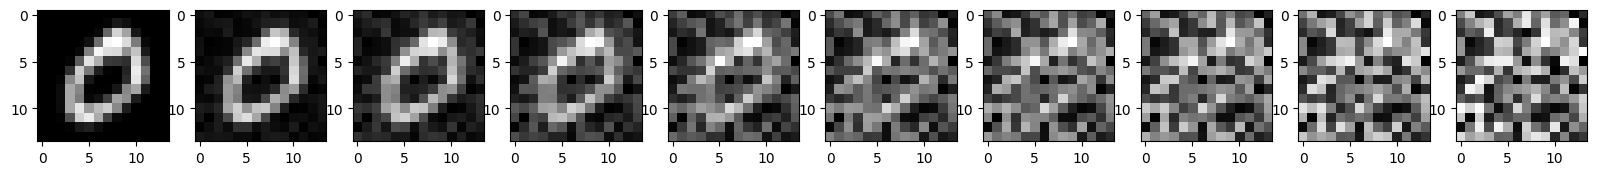

In [24]:
timeline = np.linspace(0, 1, 10)
img, noise = dataset[0]


images = []
fig, ax = plt.subplots(1,10, figsize=(20,40))

for i, t in enumerate(timeline):

    im = t*noise + (1-t)*img
    im = (im - torch.min(im))/(torch.max(im) - torch.min(im))
    images.append(images)

    ax[i].imshow(im[0], cmap='grey')




100%|██████████| 1000/1000 [00:23<00:00, 41.68it/s]


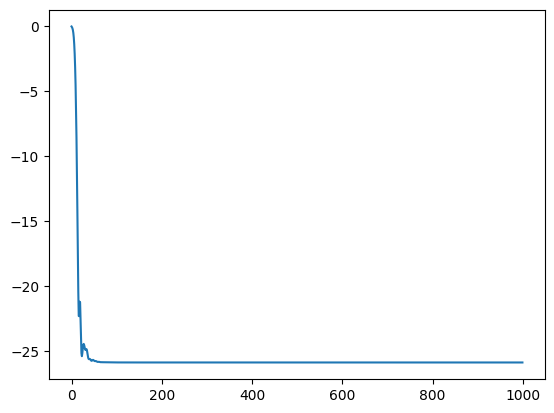

In [50]:


model = MLP(14*14+1,512,1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
epochs = 1000

losses = []

for epoch in tqdm(range(epochs)):

    model.train()

    running = 0
    for i, (img_batch, noise_batch) in enumerate(dataloader): 

        optimizer.zero_grad()

        flat_img_batch = img_batch.flatten(start_dim=1)
        flat_noise_batch = noise_batch.flatten(start_dim=1)

        timeline = torch.linspace(0.001,0.999,999)

        loss = model.action_loss_2(flat_img_batch, flat_noise_batch, timeline)
        loss.backward()
        optimizer.step()

        running += loss.item()

    losses.append(running/len(dataloader))

plt.plot(losses)
#plt.ylim((-10000, 100))

## Image Generation

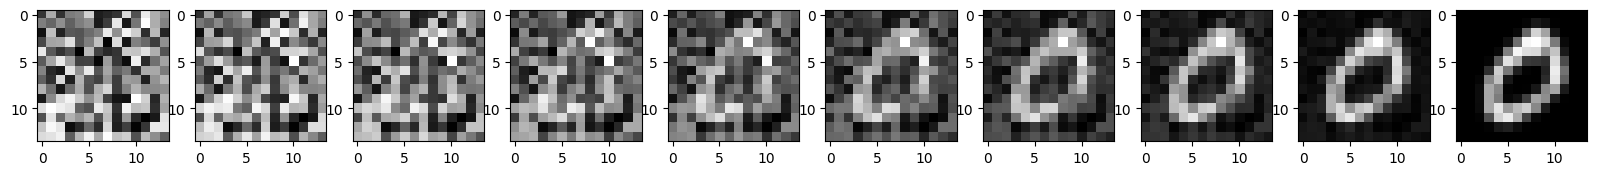

In [51]:
timeline = np.linspace(0, 1, 10)
img, noise = dataset[0]

noise = torch.rand_like(img)


images = []
fig, ax = plt.subplots(1,10, figsize=(20,40))

for i, t in enumerate(timeline):

    im = t*img + (1-t)*noise
    im = (im - torch.min(im))/(torch.max(im) - torch.min(im))
    images.append(images)

    ax[i].imshow(im[0], cmap='grey')


In [ ]:
dt = 0.01
images = [noise[0]]
flat_img = noise.flatten(start_dim=1)

for i,t in enumerate(torch.linspace(0, 0.99, 100)):

    t = t.expand(noise.shape[0], 1)
    dx = model.derivative_dsdx(flat_img, t)
    
    flat_img = flat_img + dx

    img = flat_img.unflatten(1, (14,14)).clone().detach()
    img = (img - torch.min(img))/(torch.max(img)- torch.min(img))

    images.append(img[0])




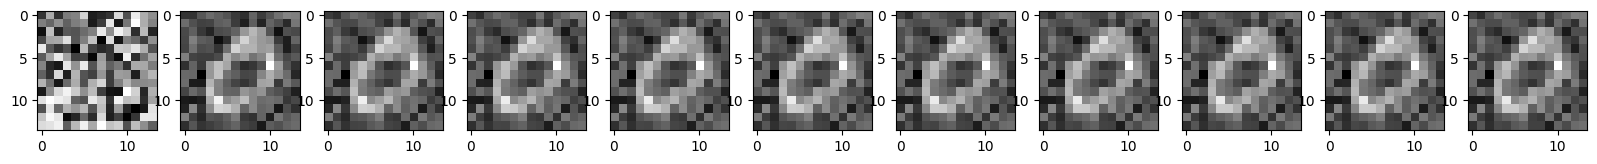

In [ ]:
fig, ax = plt.subplots(1,11, figsize=(20,40))

ax[0].imshow(images[0], cmap='grey')

for i,t in enumerate(torch.linspace(0, 0.99, 100)):

    if (i+1)%10:
        ax[int((i+1)/10)+1].imshow(images[int((i+1)/10)+1], cmap='grey')